## Première partie sur les bras et l'algorithme UCB($\delta$)

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from load_dataset import f_load_dataset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from bandits_utils import *
from films_utils import *
from evaluation_utils import *


# Import Movie dataset

In [2]:
## On load le dataset des movies dans la matrice Ratings
Ratings = f_load_dataset()

In [3]:
## On définit une seed pour la reproductibilité des résultats
np.random.seed(81)

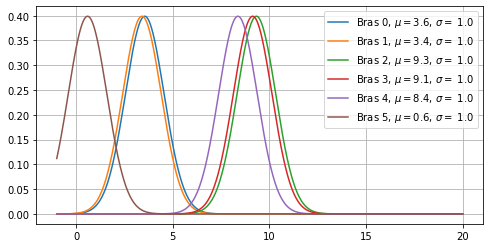

In [4]:
## Prenons k = 6 bras que l'on modélise par des gaussiennes de moyennes mu et de variance 1
k = 6 ##On peut changer librement k pour ajouter ou enlever des bras
means = [10*np.random.rand() for i in range(k)]
std = [1 for i in range(k)]

##On plot les distributions
plt.figure(figsize = (8,4))
x = np.linspace(-1,20,2000)
for i in range(k):
    plt.plot(x, sp.norm.pdf(x, means[i], std[i]), label = "Bras {}, $\mu = ${:.1f}, $\sigma =$ {:.1f}".format(i, means[i], std[i]))
plt.legend(prop={'size': 10})
plt.grid()

In [5]:
##Paramètres, n le nombre de rounds, on prend delta = O(1/n^2)
n = 1000 ##Attention, pour n trop grand, le temps de calcul devient important
delta = 1/(n**2)

X_t, Rn, arms, mu= UCB_delta(n, delta, k, means, std)

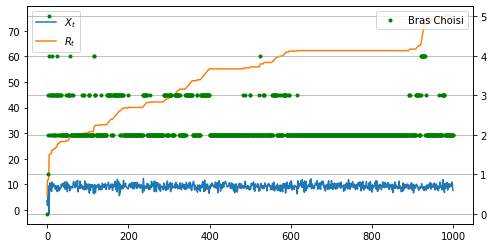

In [6]:
##On plot les différentes quantités
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(X_t, label= "$X_{t}$")
ax.plot(Rn, label ="$R_{t}$" )
plt.legend()

ax2 = ax.twinx()
ax2.plot(arms, "g.", label = "Bras Choisi")
plt.legend()
plt.grid()

## Partie LinUCB

In [7]:
#Dimension used in the decomposition of the matrix Ratings
d = 1
#Selecting a user for the Linear UCB (removed from the matrix decomposition which is going to be the context for our algorithm)
user = 3

#On réalise une factorisation de H en enlevant le user
H = non_neg_decomp(np.delete(Ratings,user,0), d)

In [8]:
## On affiche les indices de film que l'utilisateur a noté ainsi que les notes correspondantes
id_and_notes = [(i, Ratings[user][i]) for i in range(len(Ratings[user])) if Ratings[user][i] > 0]
print("Id du film, Note du film")
for elem in id_and_notes:
    print("     "+str(elem[0]) + "         " + str(elem[1]))

Id du film, Note du film
     12         5.0
     24         4.0
     52         4.0
     58         4.0
     63         2.0
     65         5.0
     69         3.0
     71         4.0
     80         5.0
     101         5.0
     128         5.0
     135         5.0
     161         5.0
     192         4.0
     197         1.0
     201         4.0


In [9]:
##On choisit le nombre d'itération 
iterations = 2000

##On applique l'algorithme
final_rec, history, regret = LinUCB(T = iterations, user = Ratings[user], H = H, d = d)

Text(0, 0.5, 'Regret')

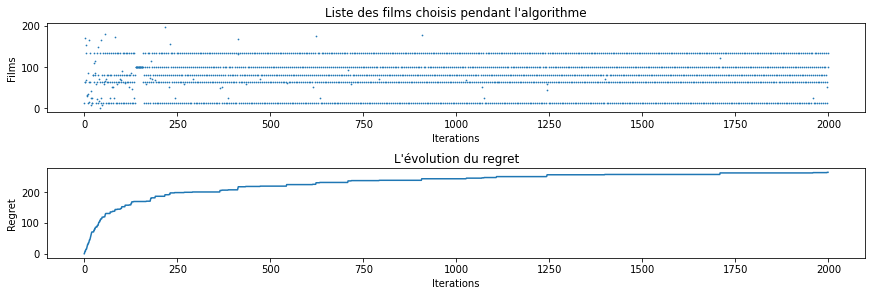

In [10]:
##On affiche les films choisis ainsi que le regret

fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(12,4))
axs[0].scatter(range(iterations),history,s=0.5)
axs[0].set_title("Liste des films choisis pendant l'algorithme")
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Films')

axs[1].plot(regret)
axs[1].set_title("L'évolution du regret")
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Regret')

# Recommandation à l'aide de la clusterisation

## On regarde les performances des paramètres qu'on choisit

Valeurs NGDC pour trois méthodes avec le Leave-One-Out :
* UCB : On recommande les films à travers l'utilisation de l'algo UCB
* Best-Average : On recommande les films par leur note moyenne
* Random : On recommande les films par hasard
   

In [11]:
##On choisit les paramètres d, nombre de clusters nb_clusters

d = 11 ##Meilleure valeur par fine tuning 
nb_clusters = 6 ##Meilleure valeur par fine tuning 
R_d = fill_matrix_MF(Ratings, d)
labels = get_labels_from_clustering(nb_clusters, R_d)
best_movies_by_cluster = get_best_movies_by_cluster(R_d, labels,nb_clusters)       

In [12]:
print('NGDC pour ucb :',gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds = 30, method = "UCB"))
print('NDGC pour best average', gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds = 30, method = "best_average"))
print('NDGC pour random rec', gain_NDGC(R_d, delta, best_movies_by_cluster, nb_clusters, nb_rounds = 20, method = "random"))

NGDC pour ucb : 0.43391017283641764
NDGC pour best average 0.3749673771203929
NDGC pour random rec 0.15214598440431823


# Recommandation pour des utilisateurs

In [13]:
##On choisit le nombre de rounds, la dimension et le nombre de clusters, 
nb_rounds = 30
d = 11
nb_clusters = 6

delta = 1/(nb_rounds**2)

R_d = fill_matrix_MF(Ratings, d)
labels = get_labels_from_clustering(nb_clusters, R_d)
best_movies_by_cluster = get_best_movies_by_cluster(R_d, labels,nb_clusters)       


# We take the new user to be a mean between 10 users of cluster 0 or 3
new_user_group0 = np.mean(R_d[labels==0][0:10],axis = 0)

new_user_group3 = np.mean(R_d[labels==3][0:10],axis = 0)

rewards_0,clusers_0,T_0,mu_0, movies_0= UCB_tot_film(nb_rounds, new_user_group0, delta, best_movies_by_cluster, nb_clusters)
rewards_3,clusers_3,T_3,mu_3, movies_3= UCB_tot_film(nb_rounds, new_user_group3, delta, best_movies_by_cluster, nb_clusters)

print("Les rewards des bras pour l'user du groupe 0 sont :", mu_0)
print("Les rewards des bras pour l'user du groupe 3 sont :", mu_3)

Les rewards des bras pour l'user du groupe 0 sont : [1.05520564 0.83367313 0.98594373 1.06809189 1.20328776 0.89759122]
Les rewards des bras pour l'user du groupe 3 sont : [1.47944571 1.0986272  1.12549481 2.97282595 3.13271136 1.37646549]


* On voit que le premier bras(bras 0) pour l'user du groupe 0 et le troisième bras pour l'user du groupe 3. Ils reprèsentent les clusters avec la meilleure note et donc l'algorithme détermine plutot bien l'appartenance de nos utilisateurs)

Les films proposés pour l'utilisateur 0 et 3 sont les suivants:
* Remarque, le nombre de film proposé est inferieur ou égal au nombre de rounds car on s'assure de ne pas recommander le même film deux fois

In [14]:
##On affiche les films proposés aux utilisateurs user_0 et user_3

print("User_0", movies_0)
print("User_3", movies_3)

User_0 [172, 41, 12, 63, 167, 35, 15, 44, 69, 154, 180, 32, 29, 149, 87, 65, 80]
User_3 [172, 41, 12, 63, 69, 154, 29, 44, 167, 35, 15, 80, 65, 24, 71, 111, 8, 135, 66, 23]


In [47]:
##On calcule le rating normalisé pour chacun des films proposés

n_u0_norm = new_user_group0[movies_0]/new_user_group0.mean()
n_u3_norm = new_user_group3[movies_3]/new_user_group3.mean()

print(n_u0_norm)
print(n_u3_norm)

[3.00611511 2.08366581 3.83174628 3.53565865 2.27639922 1.30246242
 1.74552898 1.72813064 2.95506478 1.97239757 1.65265946 1.67680899
 1.91077008 2.02482885 2.09958727 3.29861504 1.33191793]
[1.87682507 2.11669588 4.50406982 4.32877743 3.80470277 4.01753487
 3.99795284 0.53092619 1.60343363 0.70759343 1.36118223 2.69468126
 3.99656567 3.52666399 2.06310838 2.78721868 3.80058331 3.79624478
 2.03242853 2.96148074]
